# Imports

In [1]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Math + stats
import numpy as np
import pandas as pd
from scipy.stats import binom

# Logistics
from os.path import sep
from tqdm import tqdm
import time

# Local modules
import nested_simulation_functions

# Enable re-load of local modules every time they are called
%load_ext autoreload
%autoreload 2
%aimport numpy 
%aimport pandas

# Parameters

In [9]:
# Structural parameters
students_per_school = 20  # Number of students in a school
n_schools_per_L1 = 10 # Number of schools in each L1 unit
n_L1s_per_L2 = 10 # Number of L1s in each L2 unit (L2 visits all L1s)
n_L2s = 1 # Number of L2s
L1_retest_percentage = 25 # Percentage of students in a school retested by L1
L2_retest_percentage_schools = 20 # Percentage of schools visited by L2 in a given L1 unit
L2_retest_percentage_students = 20 # Percentage of students retested by L2 (from eligible students, i.e. 
                                        # those retested by L1)

# Subjects parameters - mean and standard deviation of scores, and granularity, i.e. the number of possible 
                                            # unique scores for a student
subjects = ['Maths', 'English', 'Tamil']
subjects_params = {
    "Maths": {"mean": 60, "std_dev": 30, "granularity": 101},
    "English": {"mean": 70, "std_dev": 20, "granularity": 101},
    "Tamil": {"mean": 55, "std_dev": 20, "granularity": 101}
}
passing_marks = {"Maths": 80, "English": 90, "Tamil": 90}  # Passing marks for each subject

# Distortion parameters (common)
measurement_error_mean = 0
measurement_error_std_dev = 1

# L0 distortion parameters
slope_L0 = 0.8  # User-defined slope for L0 distortion

# L1 distortion parameters
collusion_index = 0.8  # Collusion index for L1 distortion
moderation_index_L1 = 0 # Moderation for L1 distortion

# L2 distortion parameters
moderation_index_L2 = 0  # Moderation index for L2 distortion

# Real scores

Text(0, 0.5, 'Number of students')

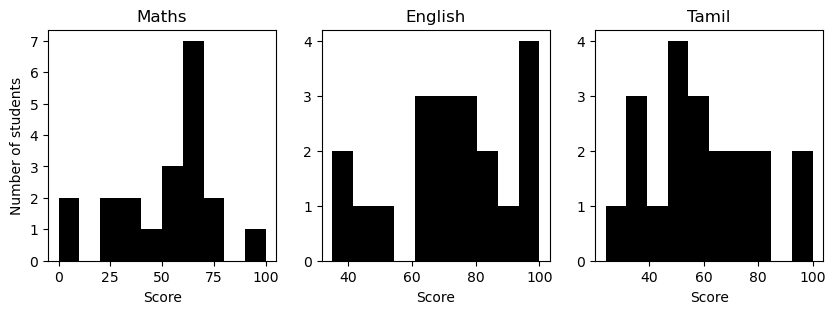

In [10]:
subjects = list(subjects_params.keys())
n_subjects = len(subjects)    

# Generate real scores
real_scores = nested_simulation_functions.generate_real_scores(students_per_school, subjects_params)

fig, ax = plt.subplots(nrows = 1, ncols = n_subjects, figsize = [10, 3])
for i in range(n_subjects):
    ax[i].hist(real_scores[subjects[i]], color = 'k')
    ax[i].set_xlabel('Score')
    ax[i].set_title(subjects[i])
    
ax[0].set_ylabel('Number of students')

# L0 scores (single school)

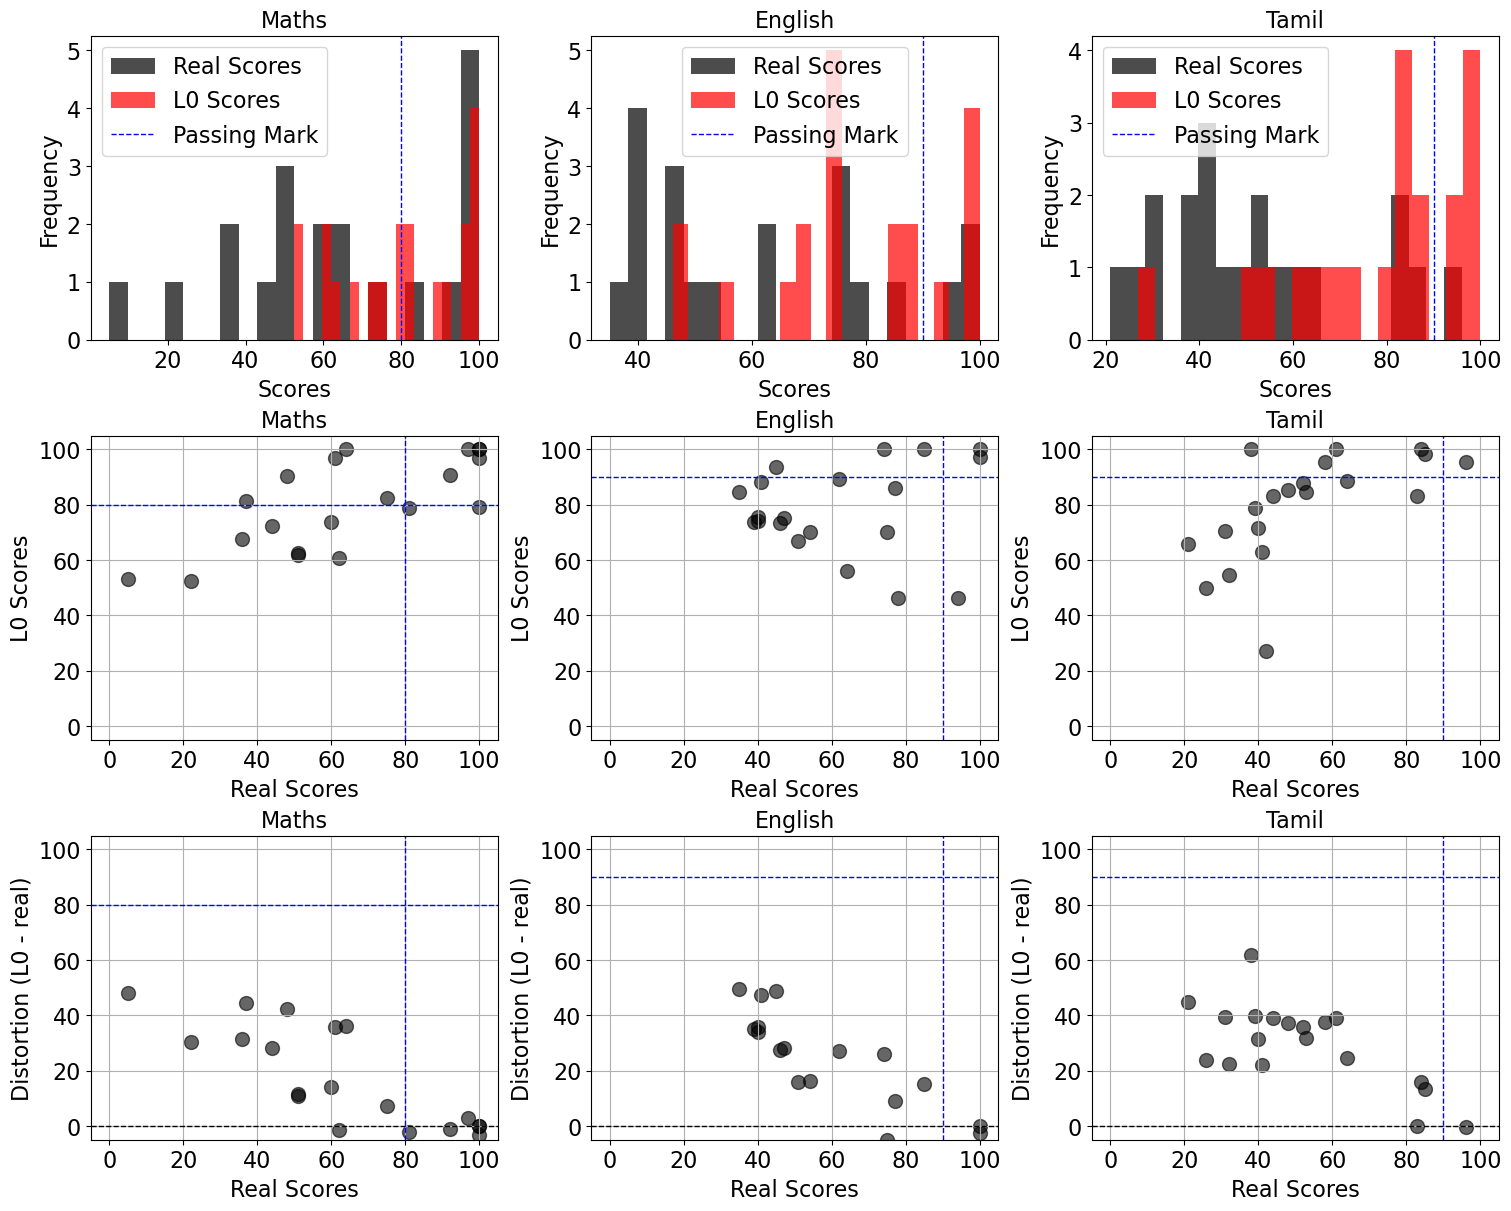

In [4]:
# Apply L0 distortions
L0_scores = nested_simulation_functions.apply_distortion_L0(real_scores, passing_marks, slope_L0,
                                                       measurement_error_mean = measurement_error_mean,
                                                    measurement_error_std_dev = measurement_error_std_dev)

# General plot settings
font_size = 16  # Font size for titles, labels, and ticks
scatter_point_size = 100  # Size of points in scatter plots
hist_color_real = "black"  # Color for real scores in histograms
hist_color_L0 = "red"  # Color for L0 scores in histograms
scatter_color = "black"  # Color for scatter plots
pass_mark_color = "blue" # Color for dashed vertical line indicating passing marks
axis_limits = [-5, 105]

# Create subplots for histograms
fig, axes = plt.subplots(3, len(subjects_params), figsize=(15, 12), constrained_layout=True)

# Plot histograms for real scores and L0 scores for each subject
for idx, subject in enumerate(subjects_params.keys()):
    
    passing_mark = passing_marks[subject]

    # Histogram for real scores
    axes[0, idx].hist(real_scores[subject], bins=20, alpha=0.7, label="Real Scores", color=hist_color_real)
    axes[0, idx].hist(L0_scores[subject], bins=20, alpha=0.7, label="L0 Scores", color=hist_color_L0)
    axes[0, idx].axvline(passing_mark, color = pass_mark_color, linestyle="--", linewidth=1, label="Passing Mark")
    axes[0, idx].set_title(subject, fontsize=font_size)
    axes[0, idx].set_xlabel("Scores", fontsize=font_size)
    axes[0, idx].set_ylabel("Frequency", fontsize=font_size)
    axes[0, idx].tick_params(axis="both", labelsize=font_size)
    axes[0, idx].legend(fontsize=font_size)

    # Scatter plot: L0 scores vs Real scores
    axes[1, idx].scatter(real_scores[subject], L0_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[1, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[1, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[1, idx].set_title(subject, fontsize=font_size)
    axes[1, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[1, idx].set_ylabel("L0 Scores", fontsize=font_size)
    axes[1, idx].tick_params(axis="both", labelsize=font_size)
    axes[1, idx].set_xlim(axis_limits)
    axes[1, idx].set_ylim(axis_limits)
    axes[1, idx].grid(True)

    distortion = L0_scores[subject] - real_scores[subject]
    axes[2, idx].scatter(real_scores[subject], distortion, alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[2, idx].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[2, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[2, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[2, idx].set_title(subject, fontsize=font_size)
    axes[2, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[2, idx].set_ylabel("Distortion (L0 - real)", fontsize=font_size)
    axes[2, idx].tick_params(axis="both", labelsize=font_size)
    axes[2, idx].set_xlim(axis_limits)
    axes[2, idx].set_ylim(axis_limits)
    axes[2, idx].grid(True)

plt.show()

# L1 scores (single school, all students)

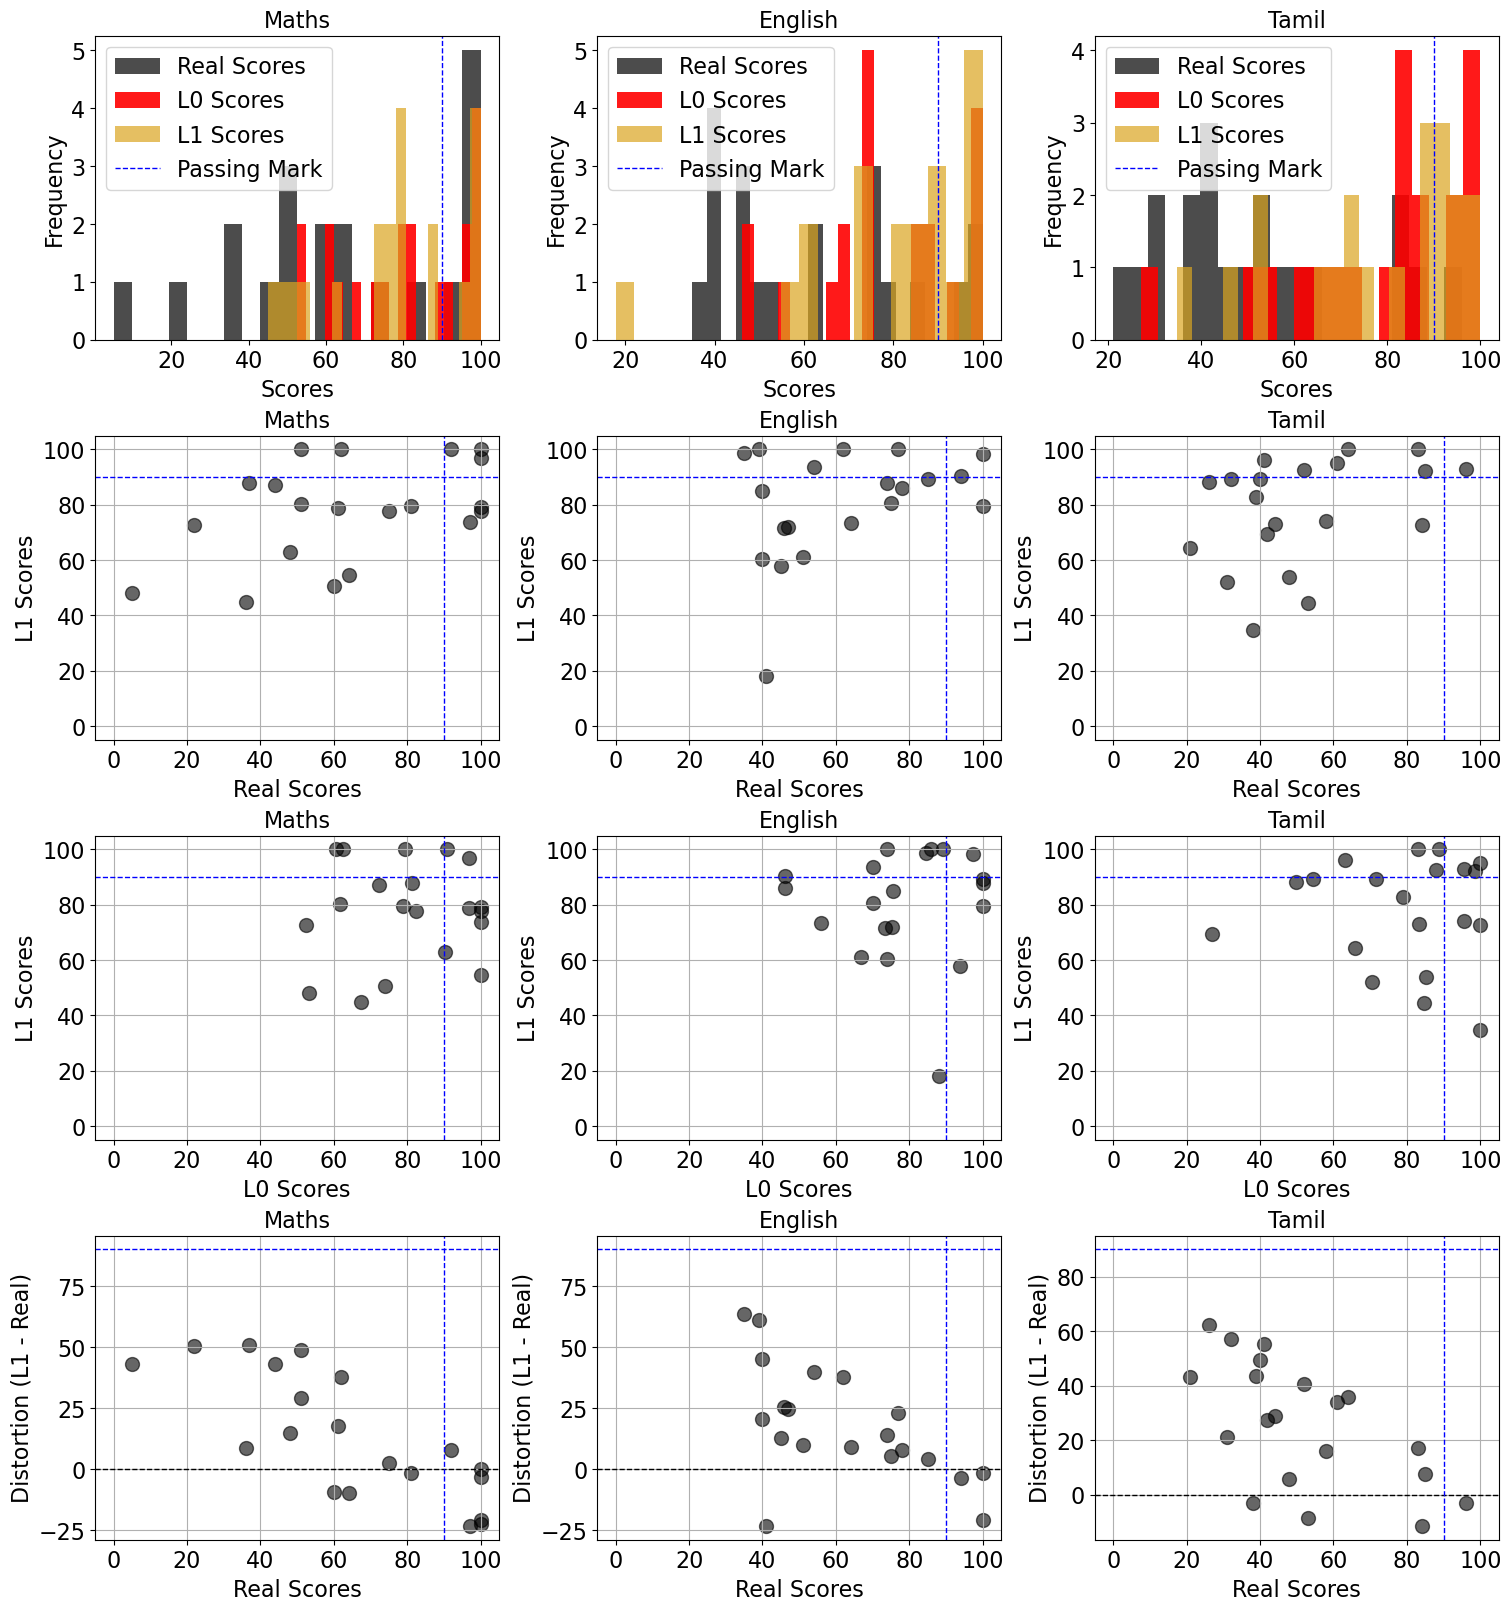

In [5]:
# Apply L1 distortions
L1_scores = nested_simulation_functions.apply_distortion_L1(real_scores, passing_marks, 
                                                            collusion_index, slope_L0, 
                                                            measurement_error_mean = measurement_error_mean, 
                                                        measurement_error_std_dev = measurement_error_std_dev,
                                                           moderation_index_L1 = moderation_index_L1)

# General plot settings
font_size = 16  # Font size for titles, labels, and ticks
scatter_point_size = 100  # Size of points in scatter plots
hist_color_real = "black"  # Color for real scores in histograms
hist_color_L0 = "red"  # Color for L0 scores in histograms
hist_color_L1 = "goldenrod"  # Color for L1 scores in histograms
scatter_color = "black"  # Color for scatter plots
pass_mark_color = "blue" # Color for dashed line indicating passing mark
axis_limits = [-5, 105]  # Axis limits for scatter plots

# Create subplots for histograms
fig, axes = plt.subplots(4, len(subjects_params), figsize=(15, 16), constrained_layout=True)

# Plot histograms for real scores, L0 scores, and L1 scores for each subject
for idx, subject in enumerate(subjects_params.keys()):
    # Histogram for real scores
    axes[0, idx].hist(real_scores[subject], bins=20, alpha=0.7, label="Real Scores", color=hist_color_real)
    axes[0, idx].hist(L0_scores[subject], bins=20, alpha=0.9, label="L0 Scores", color=hist_color_L0)
    axes[0, idx].hist(L1_scores[subject], bins=20, alpha=0.7, label="L1 Scores", color=hist_color_L1)
    axes[0, idx].axvline(passing_mark, color = pass_mark_color, linestyle="--", linewidth=1, label="Passing Mark")
    axes[0, idx].set_title(subject, fontsize=font_size)
    axes[0, idx].set_xlabel("Scores", fontsize=font_size)
    axes[0, idx].set_ylabel("Frequency", fontsize=font_size)
    axes[0, idx].tick_params(axis="both", labelsize=font_size)
    axes[0, idx].legend(fontsize=font_size)

    # Scatter plot: L1 scores vs Real scores
    axes[1, idx].scatter(real_scores[subject], L1_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[1, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[1, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[1, idx].set_title(subject, fontsize=font_size)
    axes[1, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[1, idx].set_ylabel("L1 Scores", fontsize=font_size)
    axes[1, idx].tick_params(axis="both", labelsize=font_size)
    axes[1, idx].grid(True)
    axes[1, idx].set_xlim(axis_limits)
    axes[1, idx].set_ylim(axis_limits)

    # Scatter plot: L1 scores vs L0 scores
    axes[2, idx].scatter(L0_scores[subject], L1_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[2, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[2, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[2, idx].set_title(subject, fontsize=font_size)
    axes[2, idx].set_xlabel("L0 Scores", fontsize=font_size)
    axes[2, idx].set_ylabel("L1 Scores", fontsize=font_size)
    axes[2, idx].tick_params(axis="both", labelsize=font_size)
    axes[2, idx].grid(True)
    axes[2, idx].set_xlim(axis_limits)
    axes[2, idx].set_ylim(axis_limits)

    # Plot distortion (L1 score - Real score) vs Real scores for each subject
    distortion = L1_scores[subject] - real_scores[subject]
    axes[3, idx].scatter(real_scores[subject], distortion, alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[3, idx].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[3, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[3, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[3, idx].set_title(subject, fontsize=font_size)
    axes[3, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[3, idx].set_ylabel("Distortion (L1 - Real)", fontsize=font_size)
    axes[3, idx].tick_params(axis="both", labelsize=font_size)
    axes[3, idx].grid(True)
    axes[3, idx].set_xlim(axis_limits)

plt.show()

# L2 scores (single school, all students)

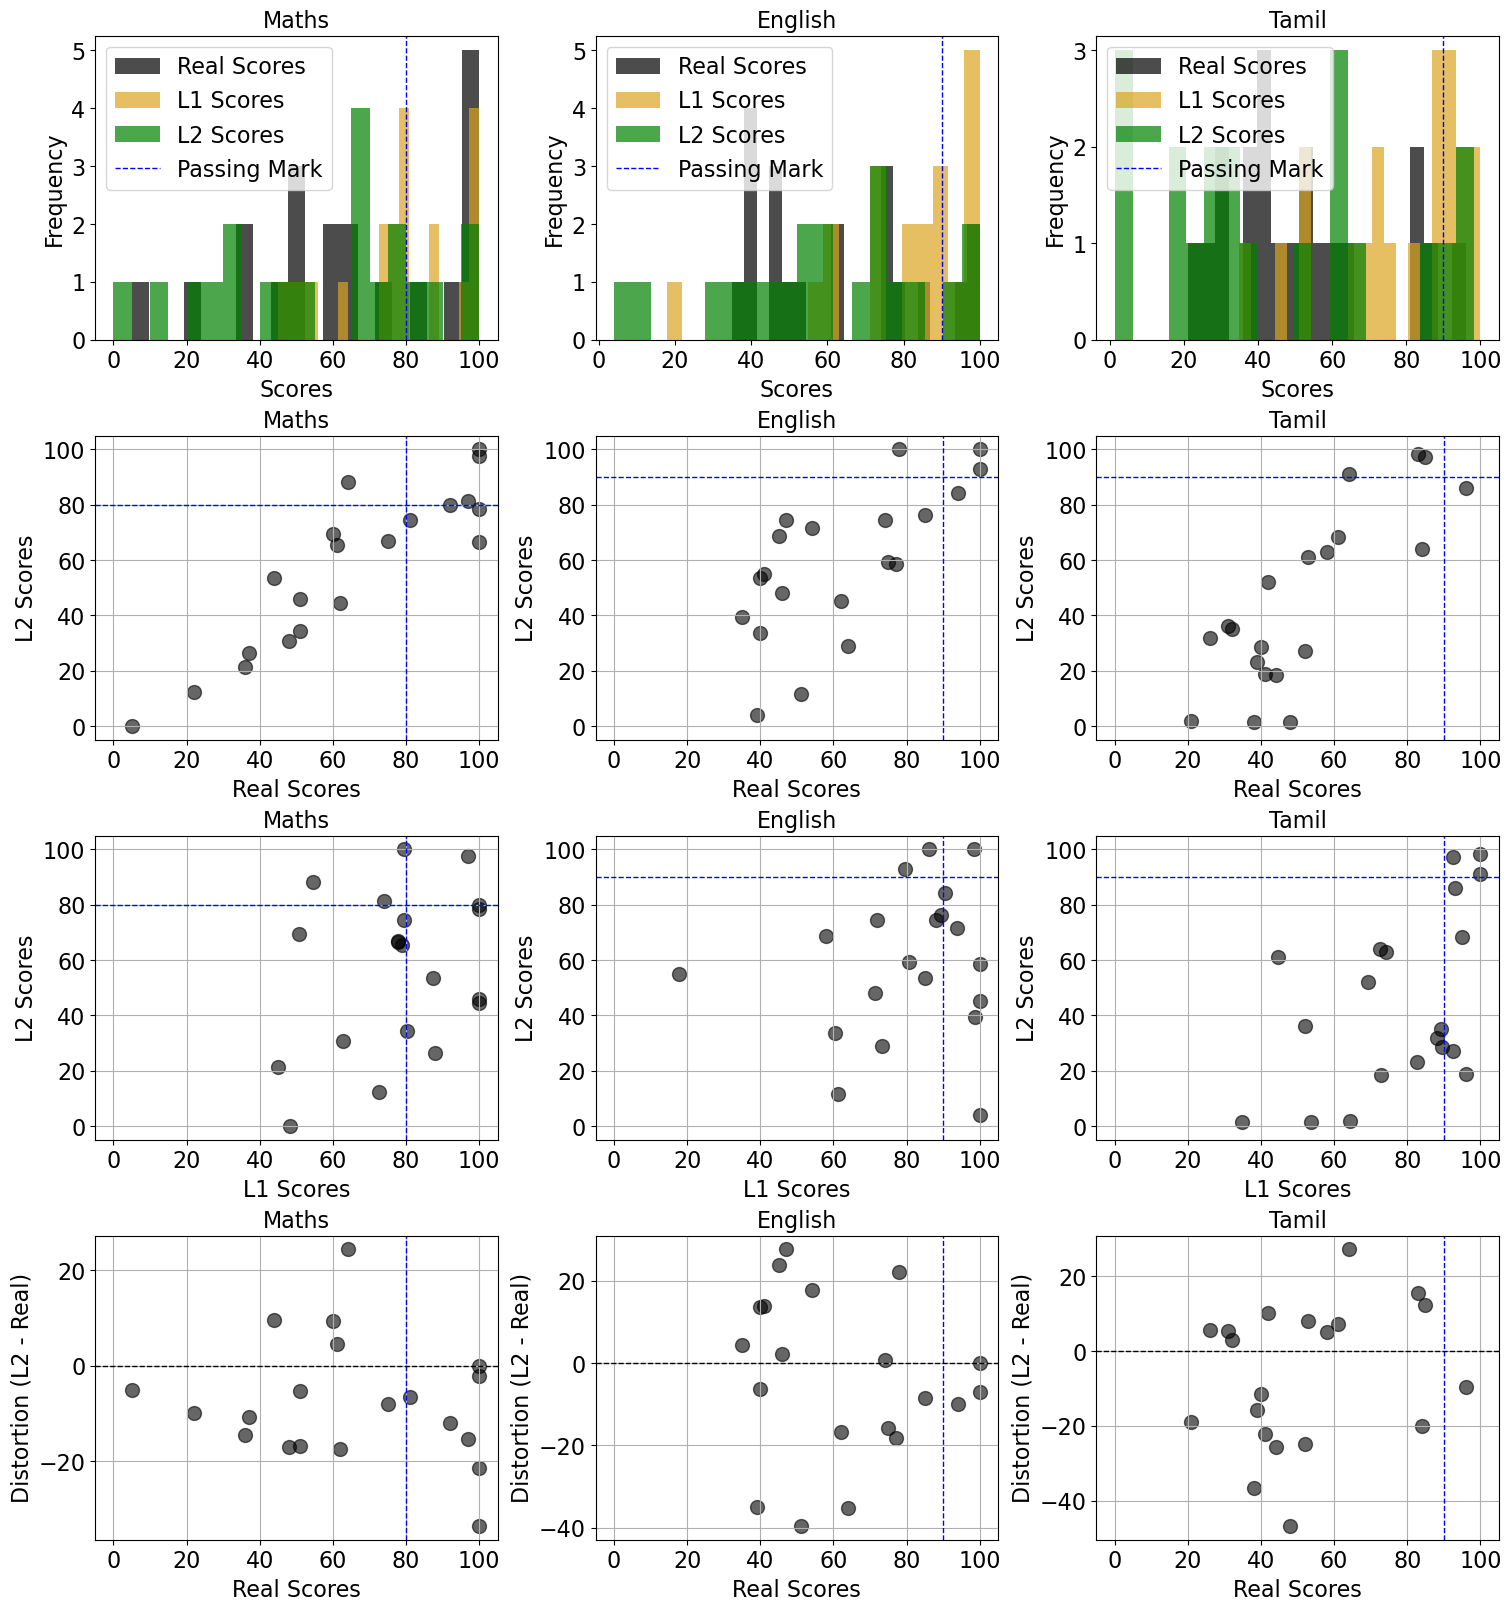

In [6]:
# Apply L2 distortions
L2_scores = nested_simulation_functions.apply_distortion_L2(real_scores, 
                                                            measurement_error_mean = measurement_error_mean, 
                                                            measurement_error_std_dev = measurement_error_std_dev, 
                                                            moderation_index_L2 = moderation_index_L2)

# General plot settings
font_size = 16  # Font size for titles, labels, and ticks
scatter_point_size = 100  # Size of points in scatter plots
hist_color_real = "black"  # Color for real scores in histograms
hist_color_L1 = "goldenrod"  # Color for L1 scores in histograms
hist_color_L2 = "green"  # Color for L2 scores in histograms
scatter_color = "black"  # Color for scatter plots
axis_limits = [-5, 105]  # Axis limits for scatter plots

# Create subplots for histograms
fig, axes = plt.subplots(4, len(subjects_params), figsize=(15, 16), constrained_layout=True)

# Plot histograms for real scores, L1 scores, and L2 scores for each subject
for idx, subject in enumerate(subjects_params.keys()):
    passing_mark = passing_marks[subject]

    # Histogram for real scores
    axes[0, idx].hist(real_scores[subject], bins=20, alpha=0.7, label="Real Scores", color=hist_color_real)
    axes[0, idx].hist(L1_scores[subject], bins=20, alpha=0.7, label="L1 Scores", color=hist_color_L1)
    axes[0, idx].hist(L2_scores[subject], bins=20, alpha=0.7, label="L2 Scores", color=hist_color_L2)
    axes[0, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[0, idx].set_title(subject, fontsize=font_size)
    axes[0, idx].set_xlabel("Scores", fontsize=font_size)
    axes[0, idx].set_ylabel("Frequency", fontsize=font_size)
    axes[0, idx].tick_params(axis="both", labelsize=font_size)
    axes[0, idx].legend(fontsize=font_size)

    # Scatter plot: L2 scores vs Real scores
    axes[1, idx].scatter(real_scores[subject], L2_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[1, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[1, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[1, idx].set_title(subject, fontsize=font_size)
    axes[1, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[1, idx].set_ylabel("L2 Scores", fontsize=font_size)
    axes[1, idx].tick_params(axis="both", labelsize=font_size)
    axes[1, idx].grid(True)
    axes[1, idx].set_xlim(axis_limits)
    axes[1, idx].set_ylim(axis_limits)

    # Scatter plot: L2 scores vs L1 scores
    axes[2, idx].scatter(L1_scores[subject], L2_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[2, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[2, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[2, idx].set_title(subject, fontsize=font_size)
    axes[2, idx].set_xlabel("L1 Scores", fontsize=font_size)
    axes[2, idx].set_ylabel("L2 Scores", fontsize=font_size)
    axes[2, idx].tick_params(axis="both", labelsize=font_size)
    axes[2, idx].grid(True)
    axes[2, idx].set_xlim(axis_limits)
    axes[2, idx].set_ylim(axis_limits)

    # Plot distortion (L2 score - Real score) vs Real scores for each subject
    passing_mark = passing_marks[subject]
    distortion = L2_scores[subject] - real_scores[subject]
    axes[3, idx].scatter(real_scores[subject], distortion, alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[3, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[3, idx].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[3, idx].set_title(subject, fontsize=font_size)
    axes[3, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[3, idx].set_ylabel("Distortion (L2 - Real)", fontsize=font_size)
    axes[3, idx].tick_params(axis="both", labelsize=font_size)
    axes[3, idx].grid(True)
    axes[3, idx].set_xlim(axis_limits)

plt.show()

# Simulate nested scores

KeyError: 'passing_mark'

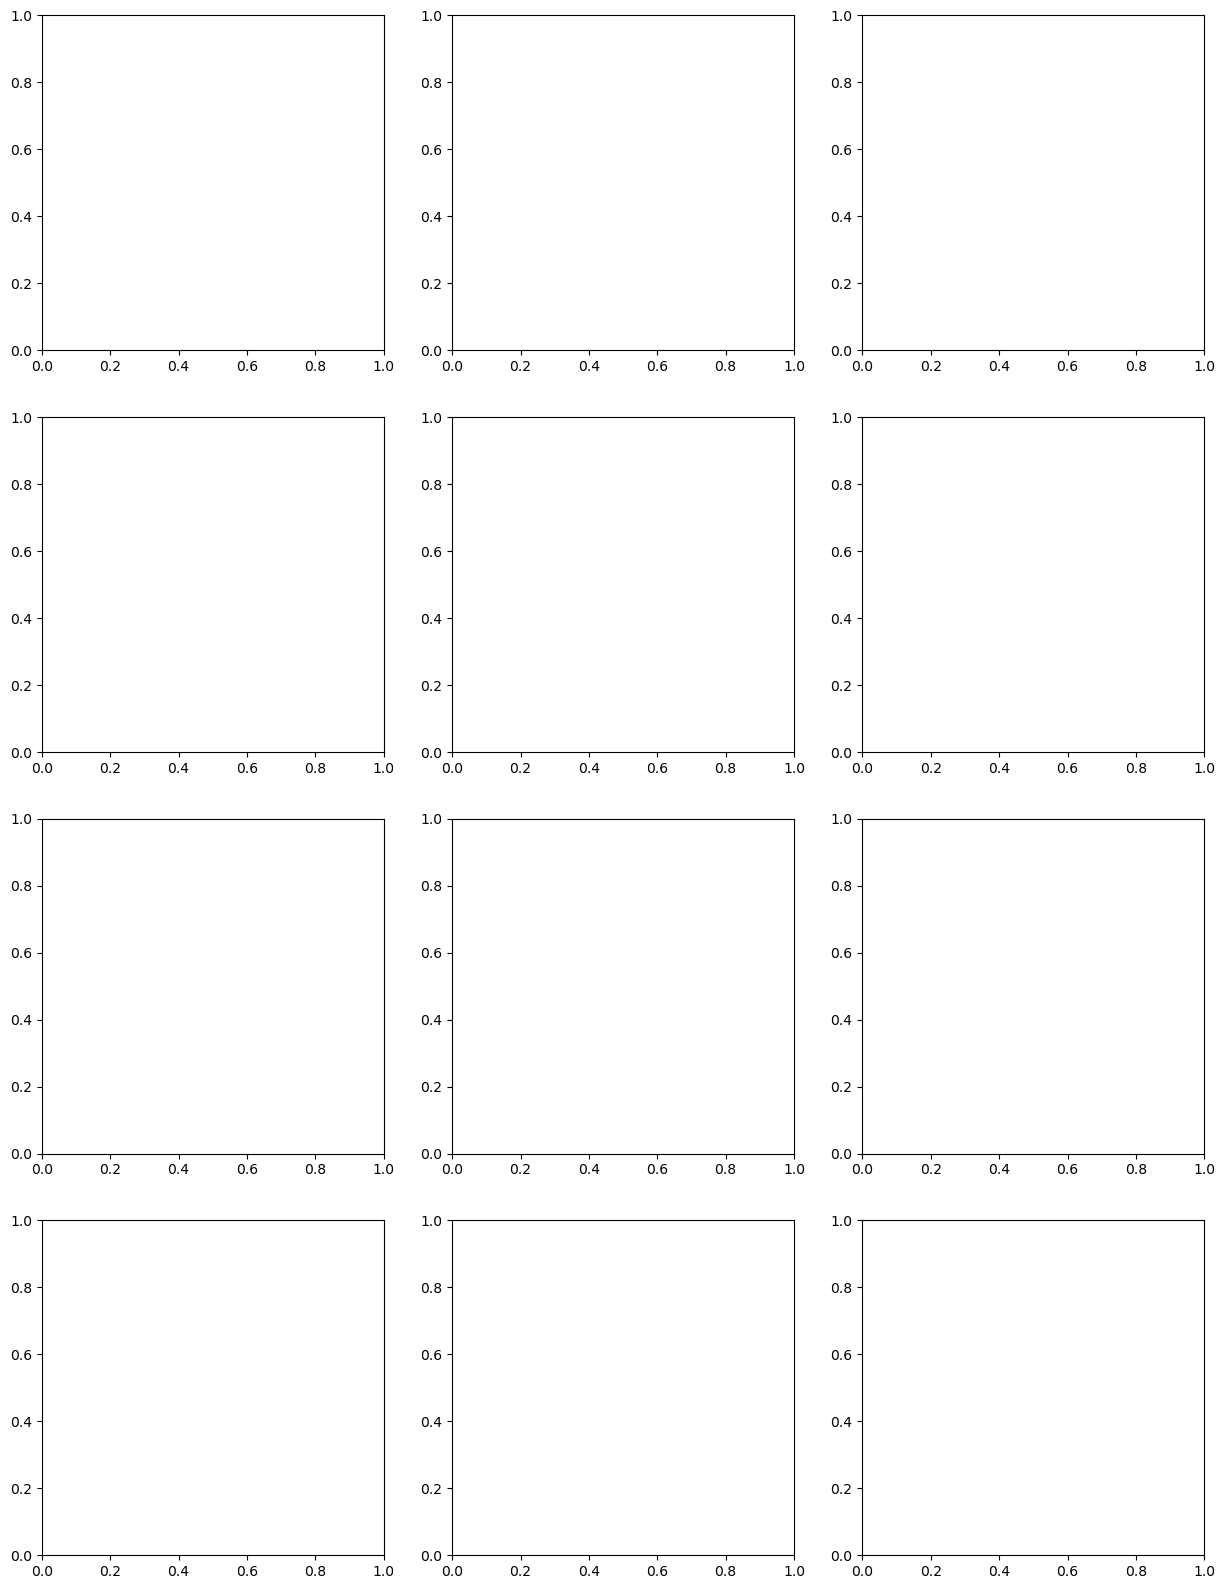

In [15]:
nested_scores = nested_simulation_functions.simulate_test_scores(
    students_per_school, 
    subjects_params, 
    passing_marks, 
    n_schools_per_L1, 
    n_L1s_per_L2, 
    n_L2s, 
    L1_retest_percentage, 
    L2_retest_percentage_schools, 
    L2_retest_percentage_students, 
    collusion_index, 
    slope_L0 = slope_L0, 
    moderation_index_L1 = moderation_index_L1, 
    moderation_index_L2 = moderation_index_L2, 
    measurement_error_mean = measurement_error_mean, 
    measurement_error_std_dev = measurement_error_std_dev
)

nested_simulation_functions.plot_nested_scores(nested_scores, subjects, subjects_params)

# Discrepancy scores

## Non-binary (using all information)

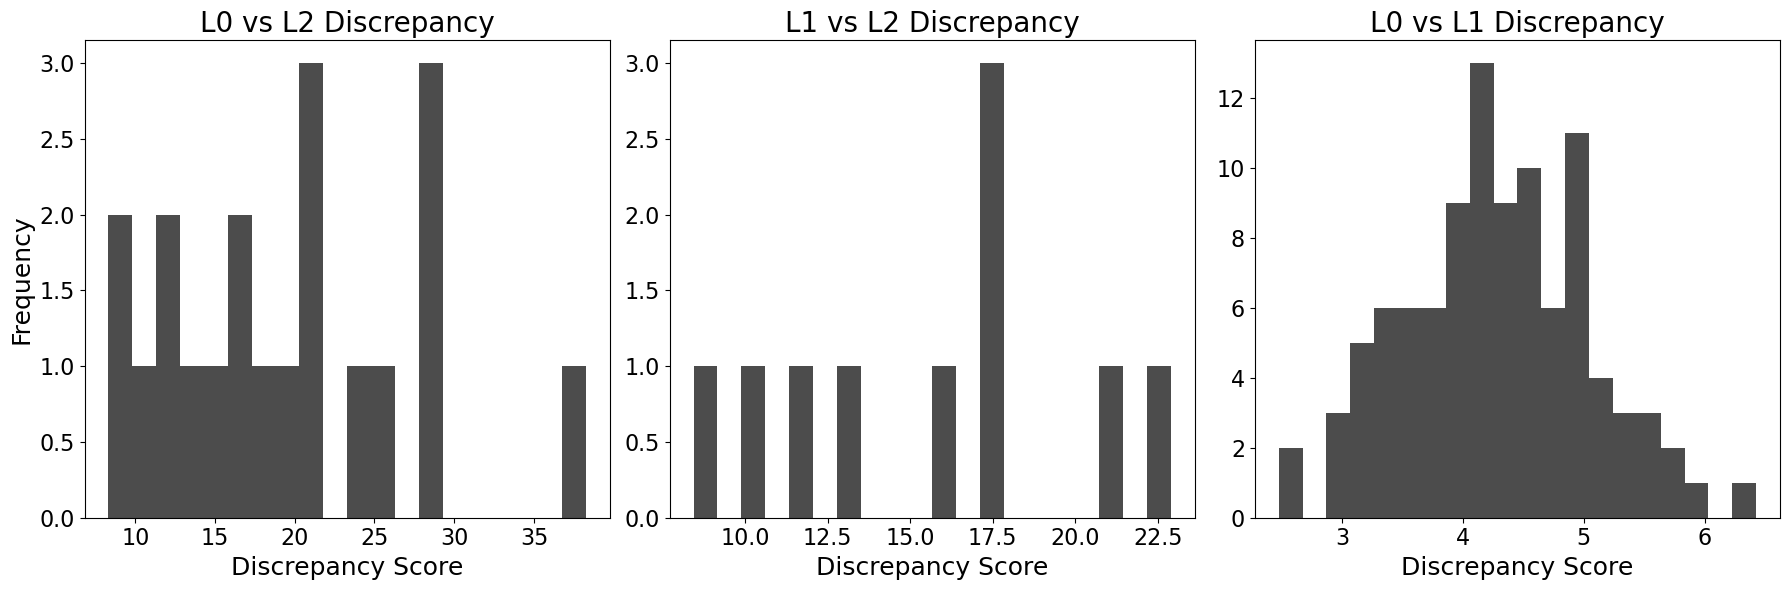

In [12]:
results = nested_simulation_functions.calculate_disc_scores(nested_scores, 'directional_difference',
                                                           passing_marks)

## Binary (pass-fail mismatch)

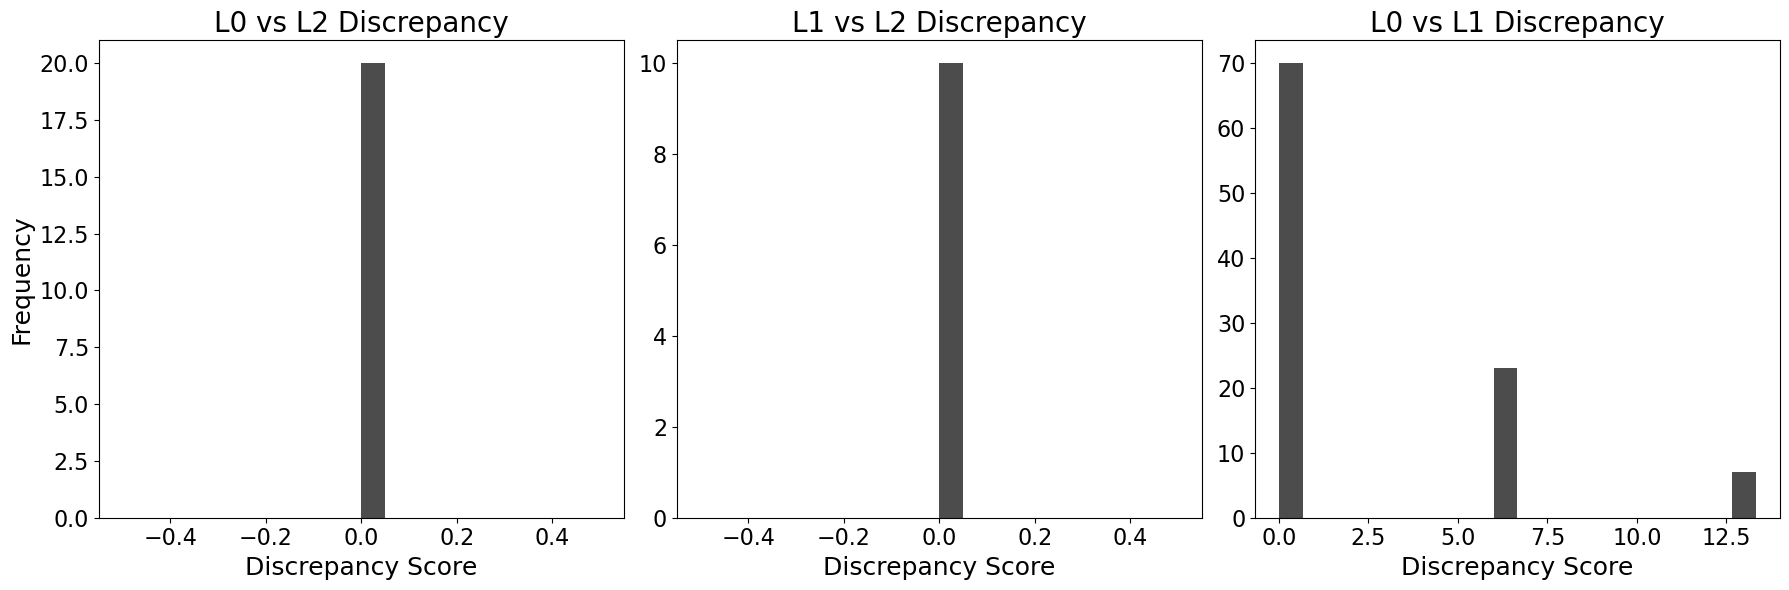

In [13]:
results = nested_simulation_functions.calculate_disc_scores(nested_scores, 'directional_percent_non_match',
                                                           passing_marks)